## Imports

In [164]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

path ='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/coursera/project/kc_house_data_NaN.csv'
data = pd.read_csv(path)

## Data Wrangling

In [260]:
data.drop('id', axis=1, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)

bedrooms_mean = data['bedrooms'].mean()
data['bedrooms'].replace(np.nan, bedrooms_mean, inplace=True)

bathrooms_mean = data['bathrooms'].mean()
data['bathrooms'].replace(np.nan, bathrooms_mean, inplace=True)

In [4]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Exploratory Data Analysis

Dataframe vazio que inclui: Root Mean Squared Error (RMSE), R-squared, Adjusted R-squared and mean of the R-squared values obtained by the k-Fold Cross Validation.

São métricas importantes para comparar diferentes modelos.
Com a evolução do projeto o DataFrame será preenchido.

Obs. R-squared perto do valor 1 e RMSE quanto menor significa um melhor fit com nosso modelo.

In [5]:
metrics = pd.DataFrame({
    'Model': [],
    'Details': [],
    'Root Mean Squared Error (RMSE)': [],
    'R-squared (training)': [],
    'Adjusted R-squared (training)':[],
    'R-squared (test)':[],
    'Adjusted R-squared (test)':[],
    'Cross Validation':[] 
})

metrics

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),Cross Validation


Para ajustar o valor do 'R-squared' para modelos que podemos usar mais de um 'feature' usamos a função 'Adjusted R-squared' dessa forma temos uma maior precissão da variação que nosso modelo terá com uma ou mais variáveis.

In [6]:
def adjustedR2(rw, n, k):
    return r2-(k-1)/(n-k)*(1-r2)

### Pearson Correlation Matrix

Vamos olhar quais das 'features' podemos escolher para prever o possível valor de uma casa.

Para isso, usando uma 'correlation matix' podemos ver qual 'feature' tem uma maior correlação com o 'price'.     

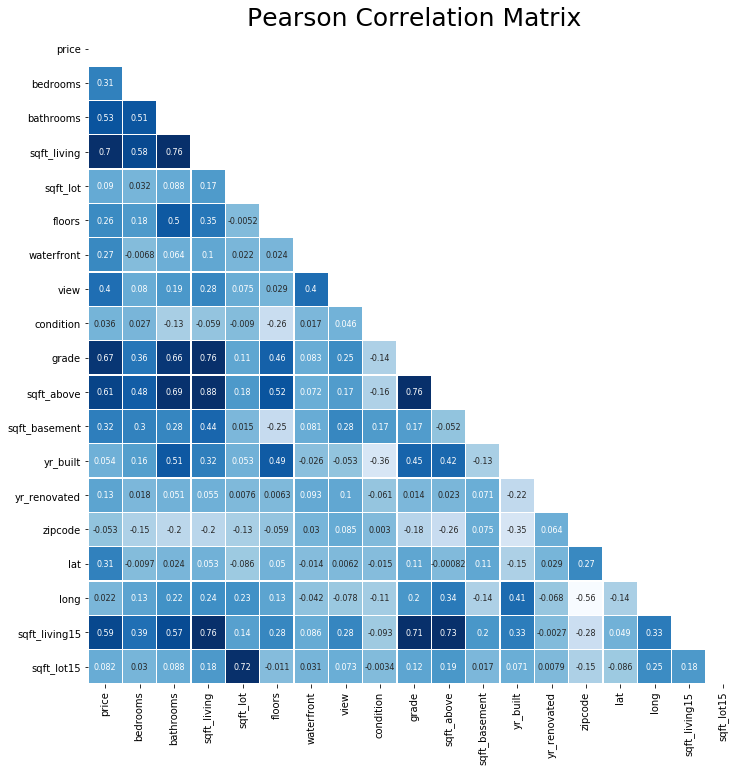

In [7]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix', fontsize = 25)

sns.heatmap(data[features].corr(),
            mask=mask,
            annot=True,
            linewidths=.5,
            vmax=0.7,
            square=True,
            cmap="Blues",
            linecolor="w",
            annot_kws={"size":8},
            cbar_kws={"shrink": .9},
            cbar=False)

Já poderiamos esperar que 'sqft_living' seria a 'feature' de maior correlação com preço. Neste caso vamos avançar em nosso estudo olhando para ela de forma isolada e conforme avançamos podemos ir adicionando outras 'features' para estudo em conjunto.

### Visualizing and Examining Data

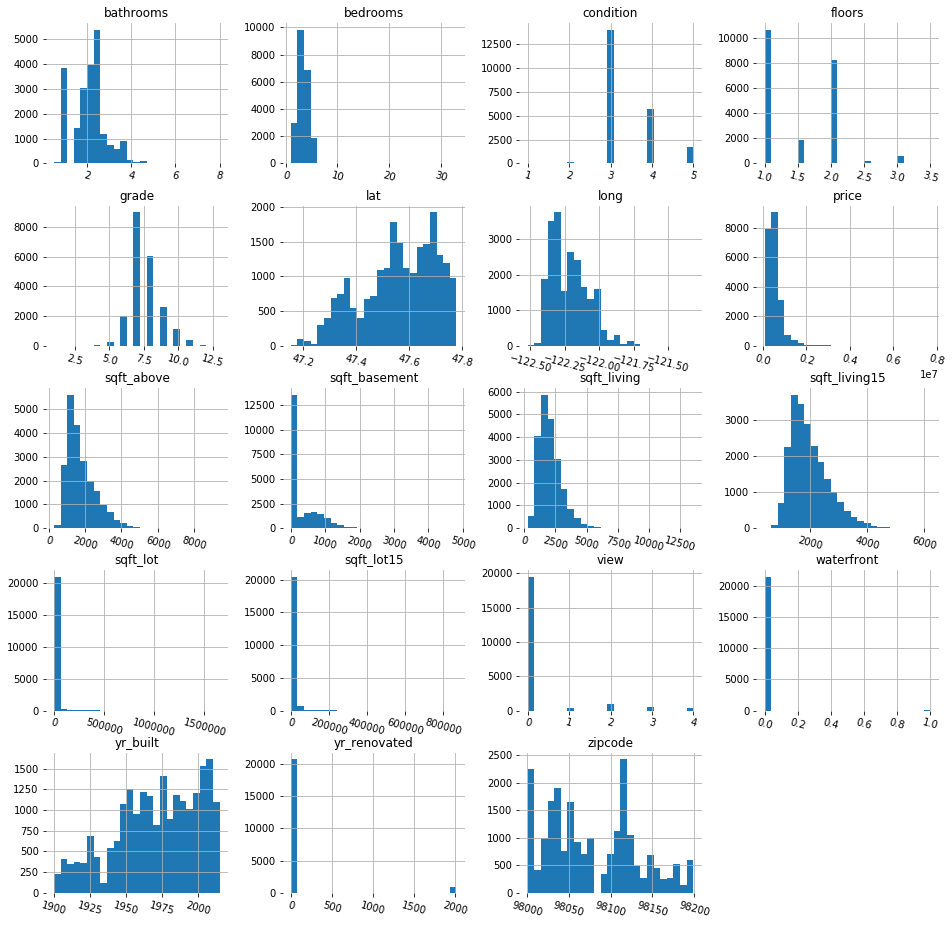

In [51]:
features = data[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]

features.hist(bins=25, figsize=(16,16), xlabelsize='10', ylabelsize='10', xrot=-15)
sns.despine(left=True, bottom=True)

In [ ]:
Bedrooms/Floors vs Price

t can be seen that there are very few houses which have some features or price appears far from others like 33 bedrooms or price around 7000000. However, determining their possible negative effect will be time consuming and in the real data sets there will always be some outliers like some luxury house prices in this dataset. That's why I am not planning to remove outliers.

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Floors')]

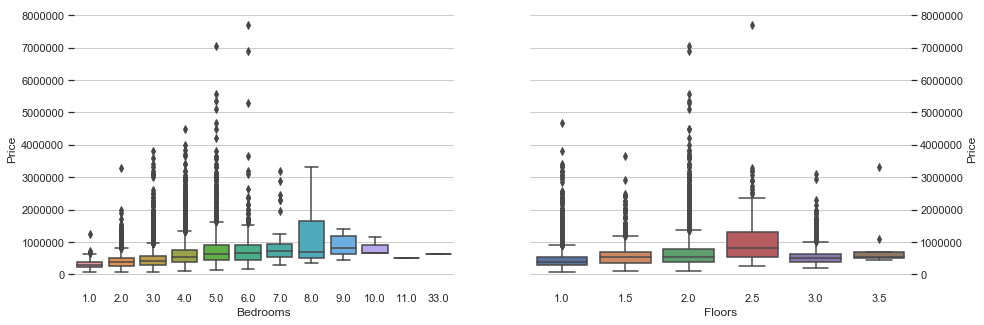

In [71]:
sns.set(style='whitegrid', font_scale=1)

f, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(x=data['bedrooms'], y=data['price'], ax=axes[0])
sns.boxplot(x=data['floors'], y=data['price'], ax=axes[1])

sns.despine(left=True, bottom=True)

axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[0].yaxis.tick_left()

axes[1].yaxis.set_label_position('right')
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Bathrooms')]

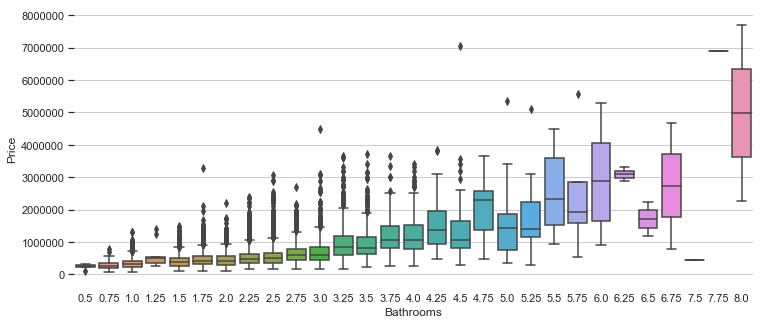

In [79]:
f, axe = plt.subplots(1, 1, figsize=(12.18, 5))

sns.despine(left=True, bottom=True)

sns.boxplot(x=data['bathrooms'], y=data['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms', ylabel='Price')

The below charts show that when the sqrt_living increases, sqrt_lot and bedrooms or bathrooms/bedrooms increases. However, the floors, bedrooms and bathrooms/bedrooms or sqrt_living does not have a similar relationship.

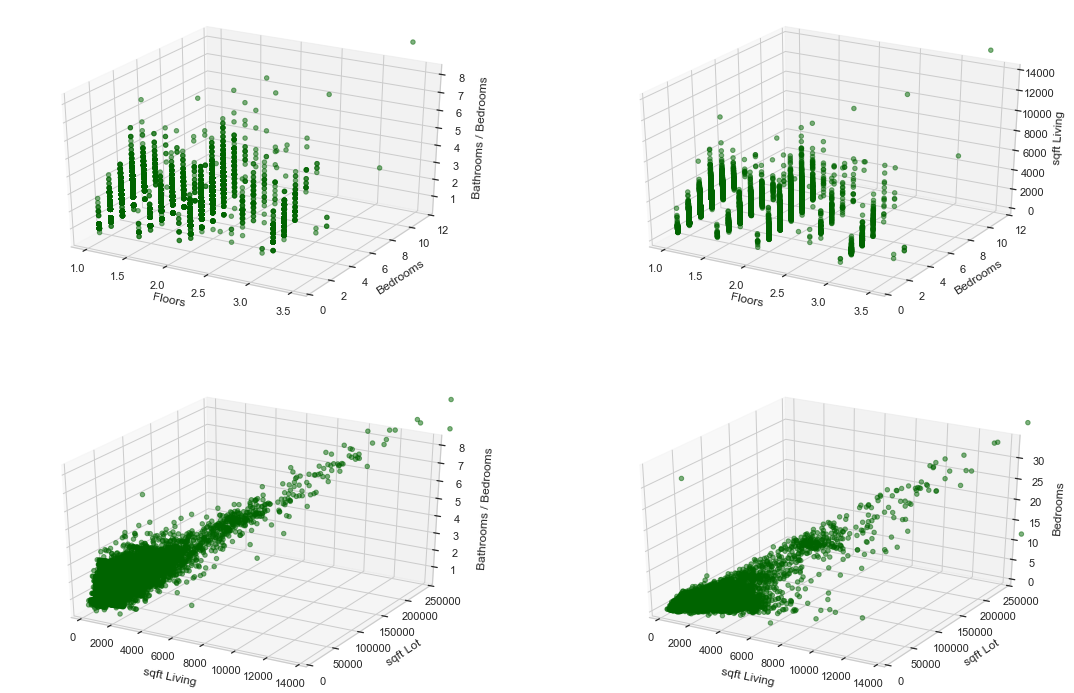

In [91]:
fig = plt.figure(figsize=(19, 12.5))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(data['floors'], data['bedrooms'], data['bathrooms'], c='darkgreen', alpha=.5)
ax.set(xlabel='Floors',ylabel='Bedrooms',zlabel='Bathrooms / Bedrooms')
ax.set(ylim=[0,12])

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(data['floors'], data['bedrooms'], data['sqft_living'], c='darkgreen', alpha=.5)
ax.set(xlabel='Floors',ylabel='Bedrooms',zlabel='sqft Living')
ax.set(ylim=[0,12])

ax=fig.add_subplot(2,2,3, projection="3d")
ax.scatter(data['sqft_living'],data['sqft_lot'],data['bathrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='\nBathrooms / Bedrooms')
ax.set(ylim=[0,250000])

ax=fig.add_subplot(2,2,4, projection="3d")
ax.scatter(data['sqft_living'],data['sqft_lot'],data['bedrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='Bedrooms')
ax.set(ylim=[0,250000]);

When we look at the below boxplots, grade and waterfront effect price visibly. On the other hand, view seem to effect less but it also has an effect on price.

The 3D plot to determine the relation between the view, grade and year built. The below chart shows that the newer houses have better grades but we can not say much about the change in the view.

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Grade')]

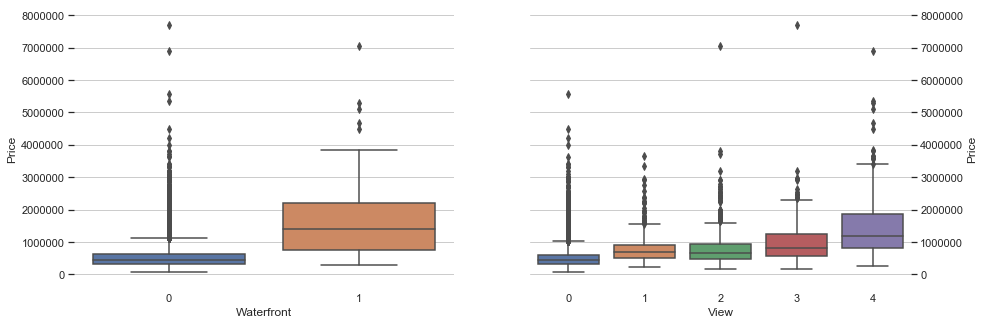

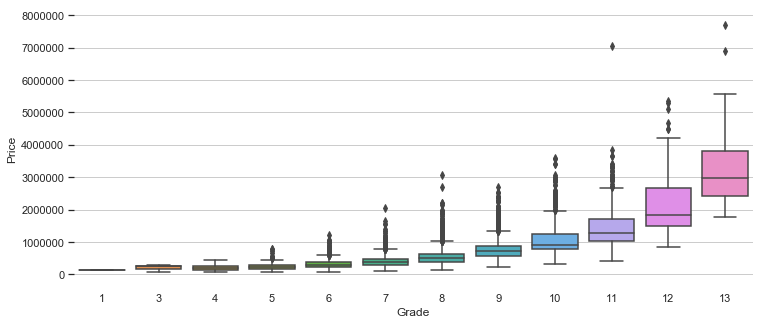

In [93]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=data['waterfront'],y=data['price'], ax=axes[0])
sns.boxplot(x=data['view'],y=data['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Waterfront', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.boxplot(x=data['grade'],y=data['price'], ax=axe)
sns.despine(left=True, bottom=True)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price')

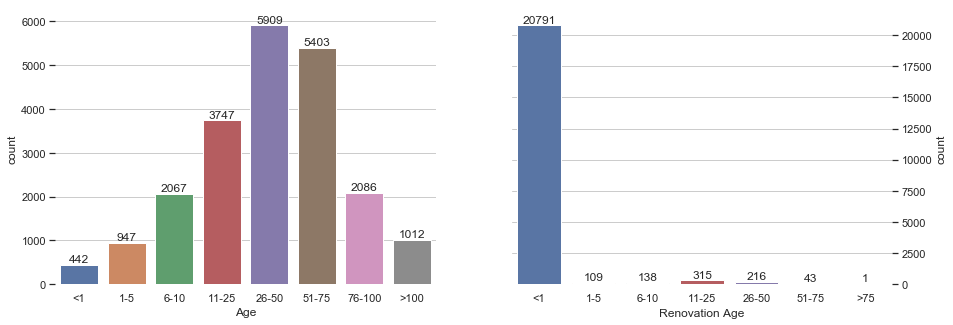

In [105]:
# just take the year from the date column
data['sales_yr']=data['date'].astype(str).str[:4]

# add the age of the buildings when the houses were sold as a new column
data['age']=data['sales_yr'].astype(int)-data['yr_built']
# add the age of the renovation when the houses were sold as a new column
data['age_rnv']=0
data['age_rnv']=data['sales_yr'][data['yr_renovated']!=0].astype(int)-data['yr_renovated'][data['yr_renovated']!=0]
data['age_rnv'][data['age_rnv'].isnull()]=0

# partition the age into bins
bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
data['age_binned'] = pd.cut(data['age'], bins=bins, labels=labels)
# partition the age_rnv into bins
bins = [-2,0,5,10,25,50,75,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','>75']
data['age_rnv_binned'] = pd.cut(data['age_rnv'], bins=bins, labels=labels)

# histograms for the binned columns
f, axes = plt.subplots(1, 2,figsize=(15,5))
p1=sns.countplot(data['age_binned'],ax=axes[0])
for p in p1.patches:
    height = p.get_height()
    p1.text(p.get_x()+p.get_width()/2,height + 50,height,ha="center")   
p2=sns.countplot(data['age_rnv_binned'],ax=axes[1])
sns.despine(left=True, bottom=True)
for p in p2.patches:
    height = p.get_height()
    p2.text(p.get_x()+p.get_width()/2,height + 200,height,ha="center")
    
axes[0].set(xlabel='Age')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Renovation Age');

# transform the factor values to be able to use in the model
df_dm = pd.get_dummies(data, columns=['age_binned','age_rnv_binned'])

### Simple Linear Regression

In [172]:
# independent features
x_data = data.drop('price', axis=1)
# dependent feature
y_data = data['price']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0])

Number of training samples:  15129
Number of testing samples:  6484


In [242]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(x_train[['sqft_living']], y_train)
predicted = lr.predict(x_test[['sqft_living']])


r_squared = lr.score(x_test[['sqft_living']],  y_test)
mse = mean_squared_error(predicted, y_test)

print('MSE: ', mse)
print('R^2: ', r_squared)

MSE:  77554859321.6244
R^2:  0.5030774643470592


In [227]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

r_squared = cross_val_score(lr, x_data[['sqft_living']], y_data, cv=4)
print('R^2: ', r_squared.mean())

predicted = cross_val_predict(lr, x_data[['sqft_living']], y_data, cv=4)

mse = mean_squared_error(predicted, y_data)
print('MSE: ', mse)

R^2:  0.49215778141759514
MSE:  68387799276.29408


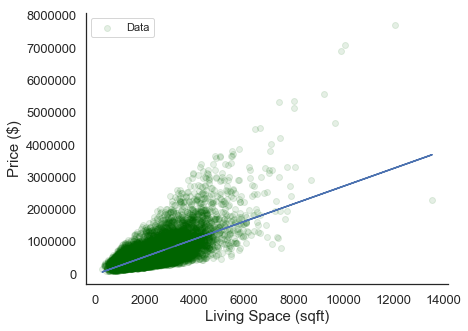

In [256]:
plt.figure(figsize=(6.5,5))
plt.scatter(x_data['sqft_living'], y_data, color='darkgreen',label="Data", alpha=.1)
plt.plot(x_test[['sqft_living']], predicted)
plt.xlabel("Living Space (sqft)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

### Multiple Linear Regression

Tran Test Split

In [312]:
# Independent features
x_data = data.drop('price', axis=1)
# Dependent feature
y_data = data['price']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=15)
print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0])

Number of training samples:  17290
Number of testing samples:  4323


Multiple Linear Regression with 5 features 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors'

In [335]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']

mlr = linear_model.LinearRegression()

# Fitting
mlr.fit(x_train[features], y_train)

# Training
yhat_train = mlr.predict(x_train[features])

# Testing
yhat_test = mlr.predict(x_test[features])

# MSE
mse_train = mean_squared_error(y_train, yhat_train)
mse_test = mean_squared_error(y_test, yhat_test)

#R^2
r_squared_train = mlr.score(x_train[features],  y_train)
r_squared_test = mlr.score(x_test[features], y_test)

print('Train R^2: ', r_squared_train.mean())
print('Test R^2: ', r_squared_test.mean())
print('Train MSE: ', mse_train)
print('Test MSE: ', mse_test)

Train R^2:  0.5087681982709211
Test R^2:  0.5088734616040858
Train MSE:  66964797732.27575
Test MSE:  63133950473.8765


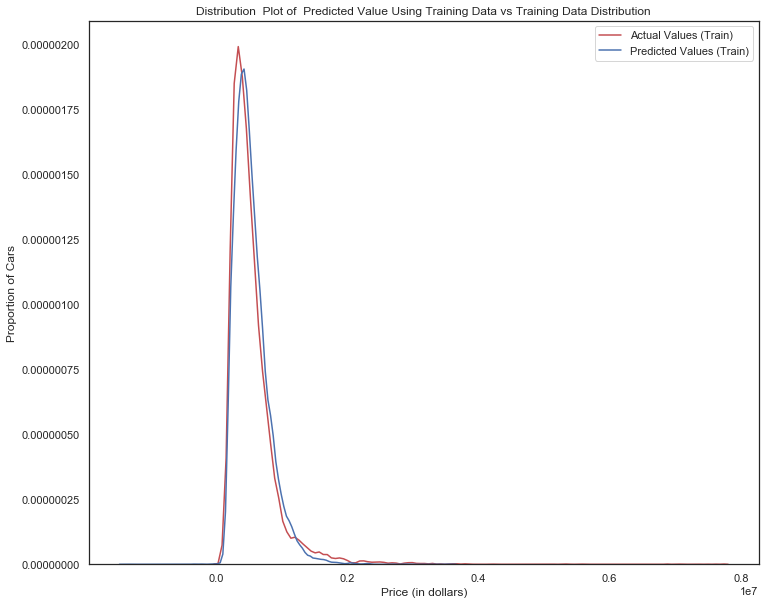

In [336]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

width = 12
height = 10
plt.figure(figsize=(width, height))

ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Values (Train)")
ax2 = sns.distplot(yhat_train, hist=False, color="b", label="Predicted Values (Train)", ax=ax1)

plt.title('Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

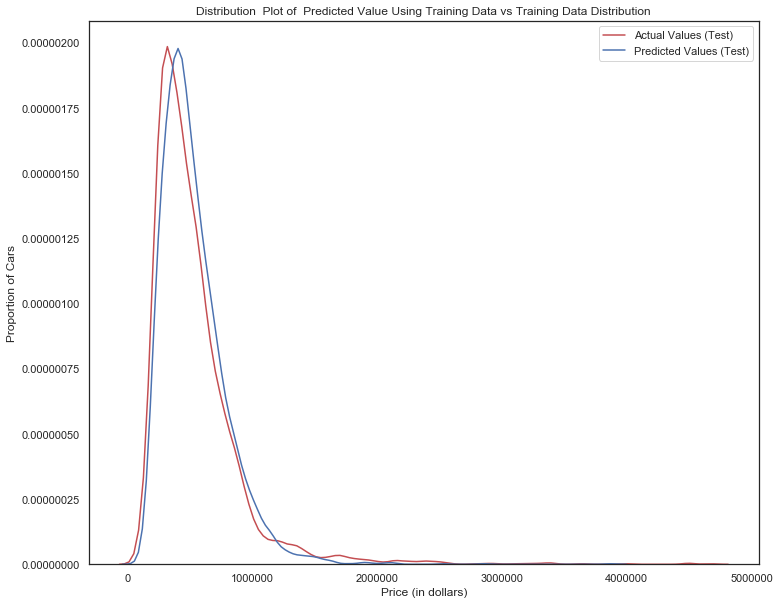

In [337]:
width = 12
height = 10
plt.figure(figsize=(width, height))

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Values (Test)")
ax2 = sns.distplot(yhat_test, hist=False, color="b", label="Predicted Values (Test)", ax=ax1)

plt.title('Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

### Polynomial

Train test split

In [437]:
# Independent features
x_data = data.drop('price', axis=1)
# Dependent feature
y_data = data['price']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=3)
print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0])

Number of training samples:  17290
Number of testing samples:  4323


Polynomial

In [454]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial
polynomial = PolynomialFeatures(degree=6)

x_train_pol = polynomial.fit_transform(x_train[['sqft_living']])
x_test_pol = polynomial.fit_transform(x_test[['sqft_living']])

# Linear Regression
poly_linear = LinearRegression()
poly_linear.fit(x_train_pol, y_train)

yhat = poly_linear.predict(x_test_pol)
yhat[0:5]

array([ 397479.0161277 , 1312400.43462891,  821751.39836629,
        297126.34494032,  370371.62183594])

In [455]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 397479.0161277  1312400.43462891  821751.39836629  297126.34494032]
True values: [ 525000. 1870000.  750000.  244900.]


We will use the function "PollyPlot" that we defined at the beginning of the lab to display the training data, testing data, and the predicted function.

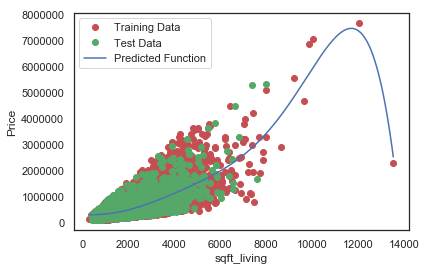

In [456]:
max([x_train[['sqft_living']].values.max(), x_test[['sqft_living']].values.max()])
min([x_train[['sqft_living']].values.min(), x_test[['sqft_living']].values.min()])

x=np.arange(xmin, xmax, 0.1)

plt.plot(x_train[['sqft_living']], y_train, 'ro', label='Training Data')
plt.plot(x_test[['sqft_living']], y_test, 'go', label='Test Data')

plt.plot(x, poly_linear.predict(polynomial.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
plt.ylabel('Price')
plt.xlabel('sqft_living')
plt.legend()
    

The lower the R^2, the worse the model, a Negative R^2 is a sign of overfitting.

In [441]:
poly_linear.score(x_train_pol, y_train)

0.5427384524530943

In [457]:
poly_linear.score(x_test_pol, y_test)

0.5442332420155923

Let's see how the R^2 changes on the test data for different order polynomials and plot the results:

Text(3, 0.75, 'Maximum R^2 ')

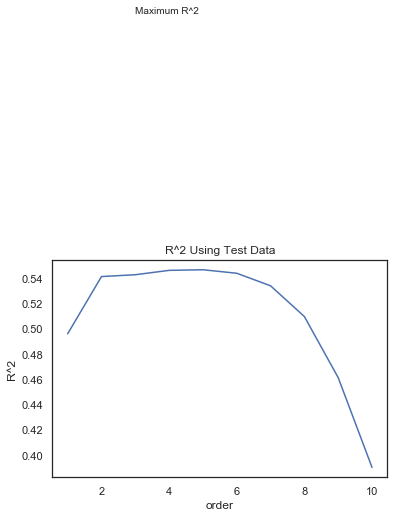

In [453]:
Rsqu_test = []

order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n in order:
    polynomial= PolynomialFeatures(degree=n)
    x_train_poly = polynomial.fit_transform(x_train[['sqft_living']])
    x_test_poly = polynomial.fit_transform(x_test[['sqft_living']])
    poly_linear.fit(x_train_poly, y_train)
    Rsqu_test.append(poly_linear.score(x_test_poly, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')   

### Ridge Regression

In [463]:
# Independent features
x_data = data.drop('price', axis=1)
# Dependent feature
y_data = data['price']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=4)
print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0])

Number of training samples:  17290
Number of testing samples:  4323


In [478]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']

polynomial = PolynomialFeatures(degree=2)
x_train_pr = polynomial.fit_transform(x_train[features])
x_test_pr = polynomial.fit_transform(x_test[features])

In [495]:
from sklearn.linear_model import Ridge

RigeModel = Ridge(alpha=0.1)
RigeModel.fit(x_train_pr, y_train)
yhat = RigeModel.predict(x_test_pr)

print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 401125.63451786 1315771.5108765   811359.26029514  276997.49560286]
test set : [ 525000. 1870000.  750000.  244900.]


We select the value of Alfa that minimizes the test error, for example, we can use a for loop.

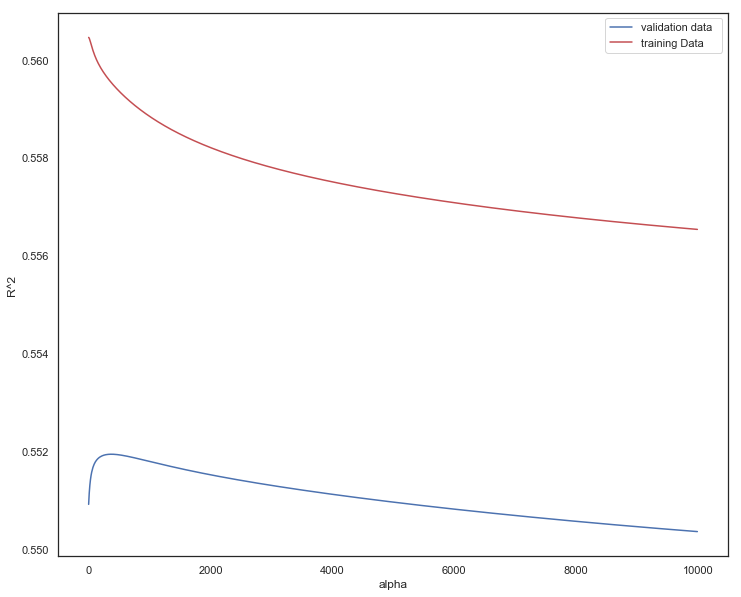

In [484]:
Rsqu_test = []
Rsqu_train = []
dummy1 = []
ALFA = 10 * np.array(range(0,1000))
for alfa in ALFA:
    RigeModel = Ridge(alpha=alfa) 
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))
    
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(ALFA,Rsqu_test, label='validation data  ')
plt.plot(ALFA,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

### Grid Search

In [501]:
from sklearn.model_selection import GridSearchCV

parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]

RR=Ridge()
RR

Grid1 = GridSearchCV(RR, parameters1,cv=4)

Grid1.fit(x_data[features], y_data)

BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [502]:
BestRR.score(x_test[features], y_test)

0.5136438615933193